First 5 rows of data:


,temperature
time,
2025-03-24 13:16:00,48.777141
2025-03-24 13:17:00,48.567533
2025-03-24 13:18:00,48.966743
2025-03-24 13:19:00,48.851532
2025-03-24 13:20:00,49.490123


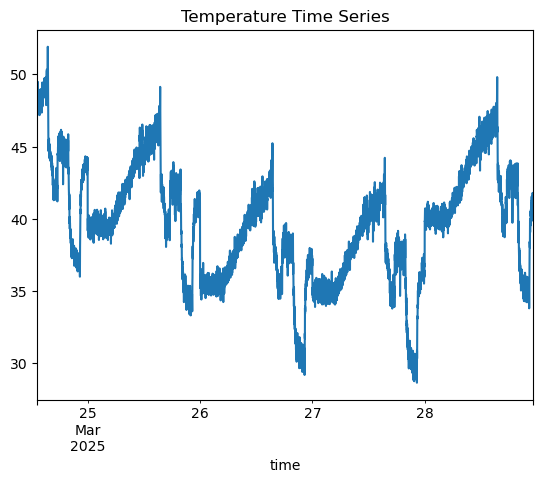

In [1]:
# Import Libraries & Load Data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data (modify path if needed)
df = pd.read_csv('Temp_humid_data.csv', parse_dates=['time'], index_col='time')
df = df.sort_index()

# Keep only temperature
df = df[['temperature']]

print("First 5 rows of data:")
display(df.head())
df['temperature'].plot(title='Temperature Time Series')
plt.show()

In [2]:
# Preprocessing & Feature Engineering
# Check missing values
print("Missing values:", df.isnull().sum())

# Create lagged features (modified for temperature only)
def create_lagged_features(df, lags, target_steps):
    data = df.copy()
    for lag in range(1, lags + 1):
        data[f'temp_lag_{lag}'] = data['temperature'].shift(lag)
    data['target_temp'] = data['temperature'].shift(-target_steps)
    data = data.drop(columns=['temperature']).dropna()
    return data

# Create datasets
lags = [5, 50]
target_steps = 10

data_5 = create_lagged_features(df, lags=5, target_steps=10)
data_50 = create_lagged_features(df, lags=50, target_steps=10)

print("\nLagged features (5 lags) sample:")
display(data_5.head())

Missing values: temperature    0
dtype: int64

Lagged features (5 lags) sample:


,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,temp_lag_5,target_temp
time,,,,,,
2025-03-24 13:21:00,49.490123,48.851532,48.966743,48.567533,48.777141,47.586059
2025-03-24 13:22:00,48.563648,49.490123,48.851532,48.966743,48.567533,47.749428
2025-03-24 13:23:00,48.530305,48.563648,49.490123,48.851532,48.966743,48.067357
2025-03-24 13:24:00,48.540498,48.530305,48.563648,49.490123,48.851532,48.033044
2025-03-24 13:25:00,48.476871,48.540498,48.530305,48.563648,49.490123,47.564685


In [3]:
# Train/Test Split 
def split_data(data):
    X = data.drop(columns=['target_temp'])
    y = data['target_temp']
    split_idx = int(len(X) * 0.8)
    return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

# Split data
X_train_5, X_test_5, y_train_5, y_test_5 = split_data(data_5)
X_train_50, X_test_50, y_train_50, y_test_50 = split_data(data_50)

print("Training shapes (5 lags):", X_train_5.shape, y_train_5.shape)
print("Test shapes (5 lags):", X_test_5.shape, y_test_5.shape)

Training shapes (5 lags): (5075, 5) (5075,)
Test shapes (5 lags): (1269, 5) (1269,)


Linear Regression Results:


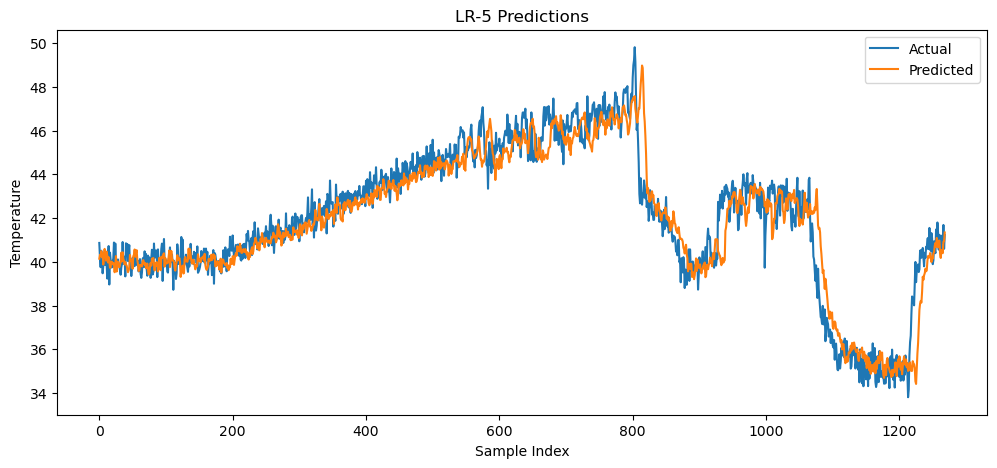

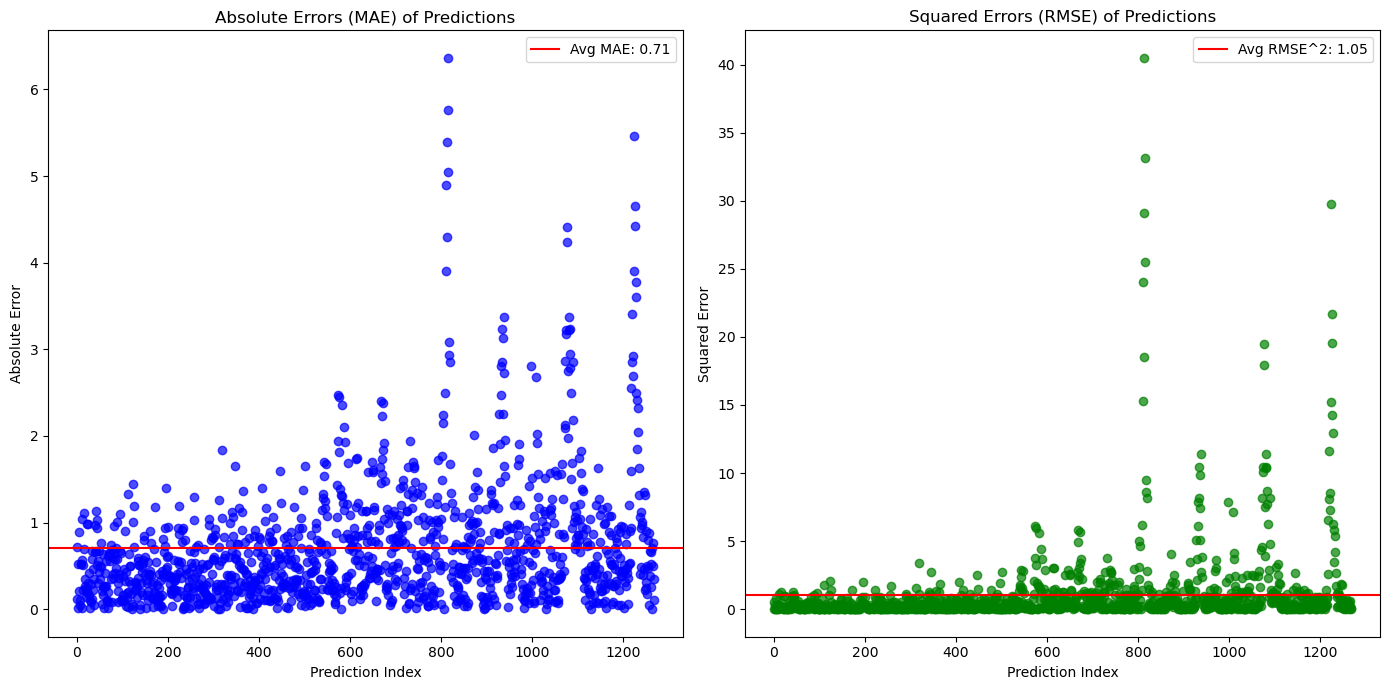

LR-5 MAE: 0.7097, RMSE: 1.0225



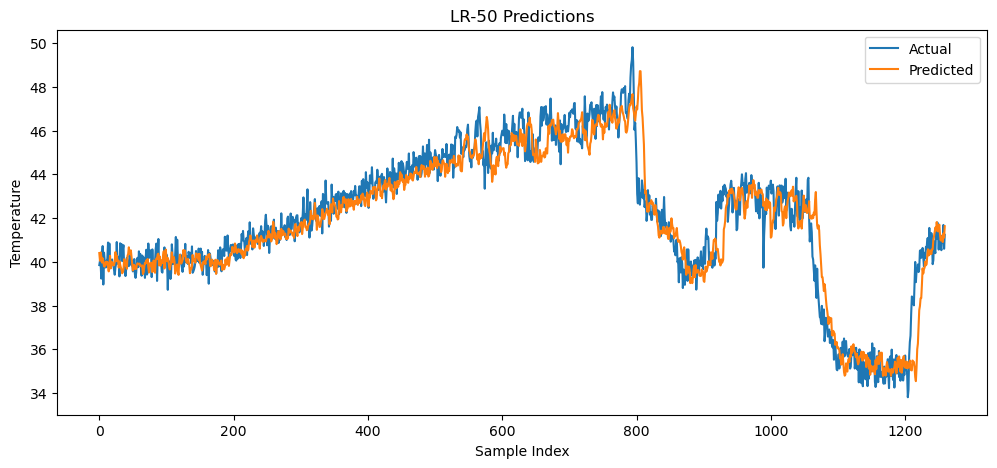

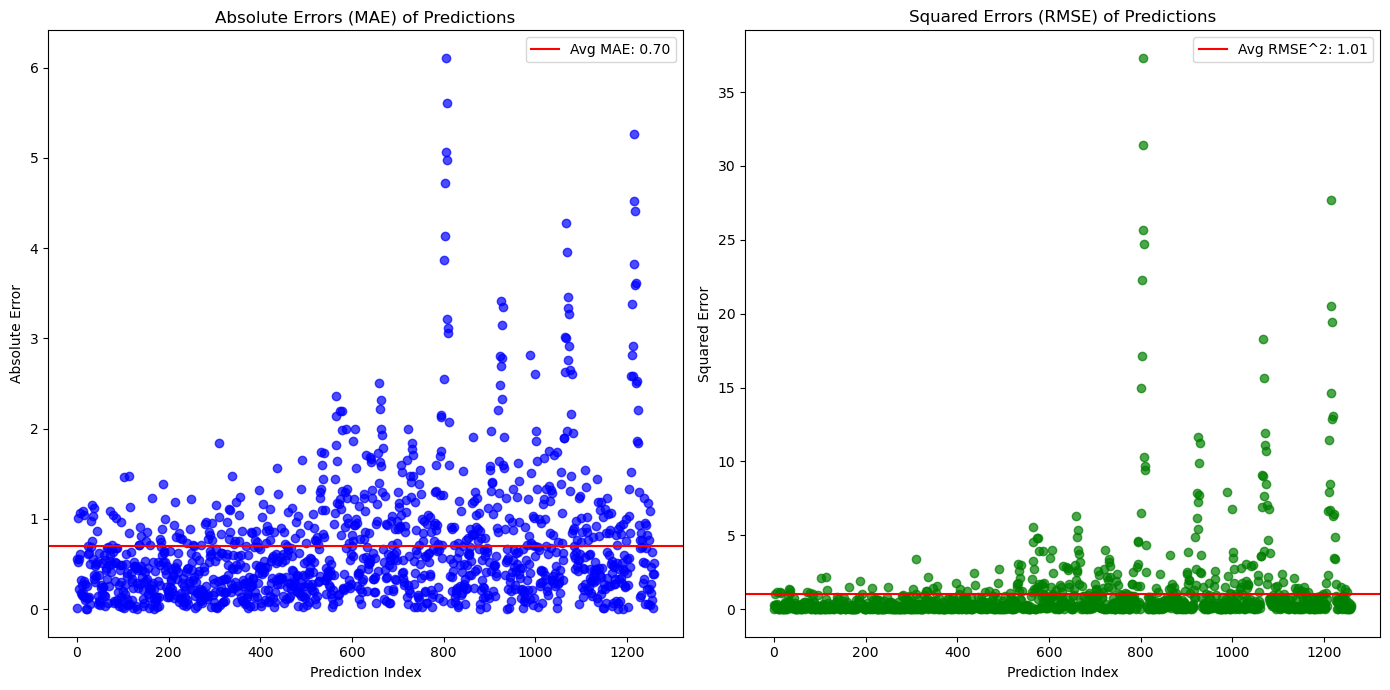

LR-50 MAE: 0.6984, RMSE: 1.0072


In [4]:
# Linear Regression Models 
def train_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{model_name} Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

    # Calculate individual absolute and squared errors
    absolute_errors = np.abs(y_test - y_pred)
    squared_errors = (y_test - y_pred) ** 2
    # Create a scatter plot for MAE and RMSE across each prediction
    plt.figure(figsize=(14, 7))

    # Plotting absolute errors
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(absolute_errors)), absolute_errors, color='blue', alpha=0.7)
    plt.title('Absolute Errors (MAE) of Predictions')
    plt.xlabel('Prediction Index')
    plt.ylabel('Absolute Error')
    plt.axhline(y=mae, color='r', linestyle='-', label=f'Avg MAE: {mae:.2f}')
    plt.legend()



    # Plotting squared errors
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(squared_errors)), squared_errors, color='green', alpha=0.7)
    plt.title('Squared Errors (RMSE) of Predictions')
    plt.xlabel('Prediction Index')
    plt.ylabel('Squared Error')
    plt.axhline(y=rmse**2, color='r', linestyle='-', label=f'Avg RMSE^2: {rmse**2:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return mae, rmse

# Scale features
scaler_5 = StandardScaler().fit(X_train_5)
X_train_5_scaled = scaler_5.transform(X_train_5)
X_test_5_scaled = scaler_5.transform(X_test_5)

scaler_50 = StandardScaler().fit(X_train_50)
X_train_50_scaled = scaler_50.transform(X_train_50)
X_test_50_scaled = scaler_50.transform(X_test_50)

# LR Models
print("Linear Regression Results:")
lr_5 = LinearRegression()
mae_lr5, rmse_lr5 = train_evaluate(lr_5, X_train_5_scaled, X_test_5_scaled, y_train_5, y_test_5, 'LR-5')
print(f"LR-5 MAE: {mae_lr5:.4f}, RMSE: {rmse_lr5:.4f}\n")

lr_50 = LinearRegression()
mae_lr50, rmse_lr50 = train_evaluate(lr_50, X_train_50_scaled, X_test_50_scaled, y_train_50, y_test_50, 'LR-50')
print(f"LR-50 MAE: {mae_lr50:.4f}, RMSE: {rmse_lr50:.4f}")


SVR Results:


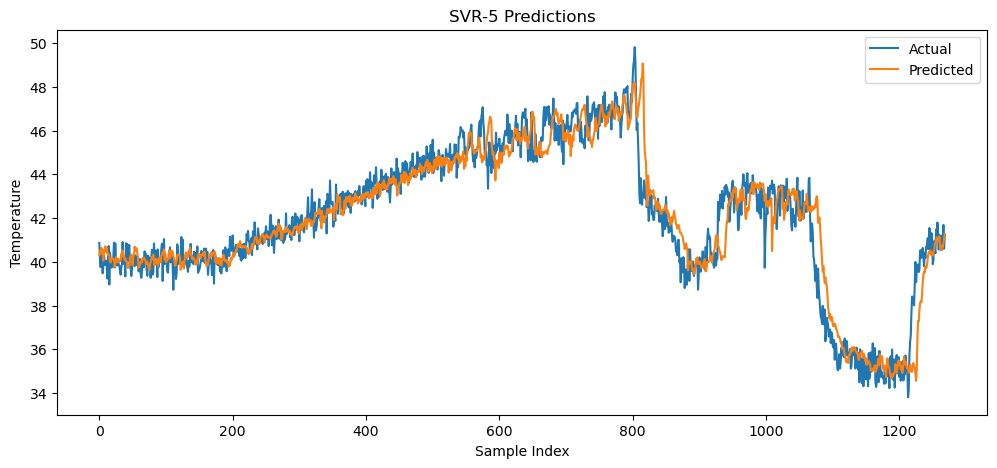

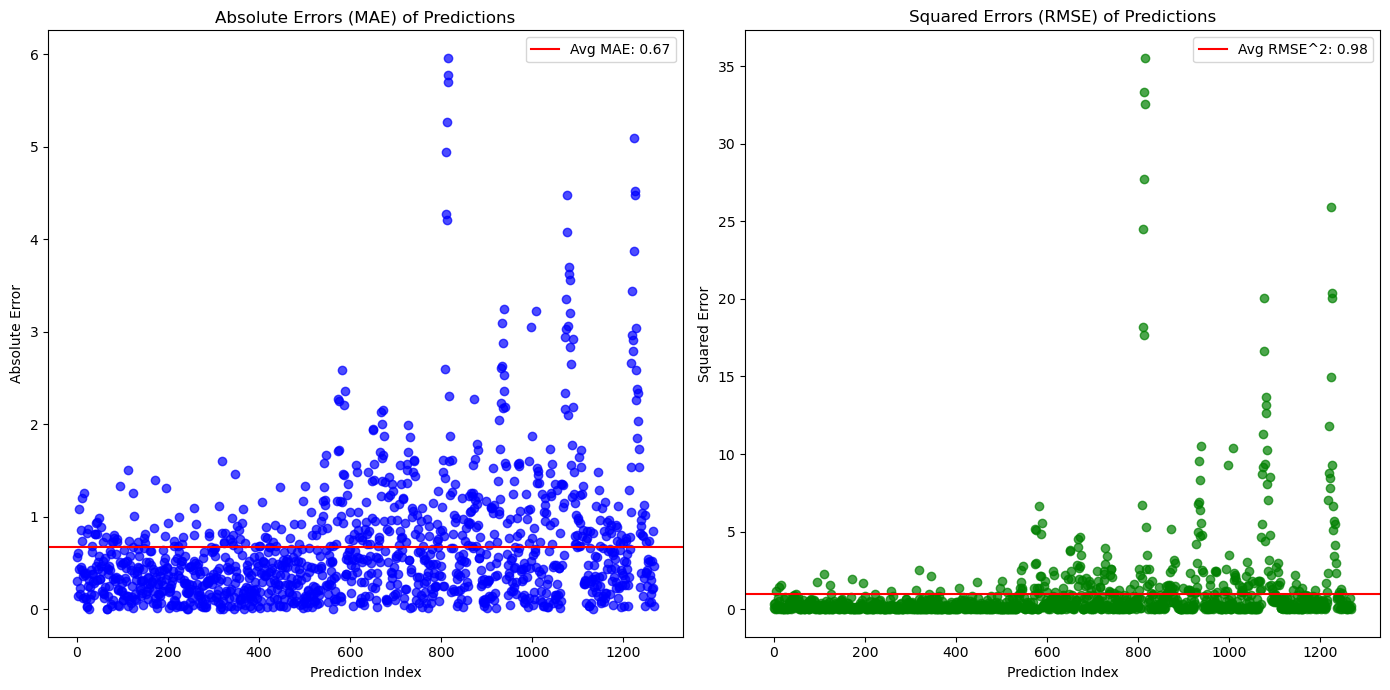

SVR-5 MAE: 0.6719, RMSE: 0.9921



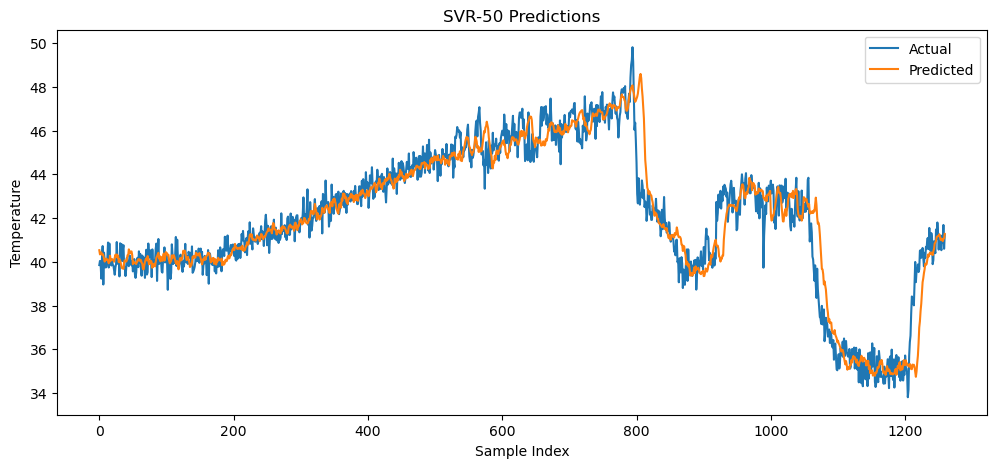

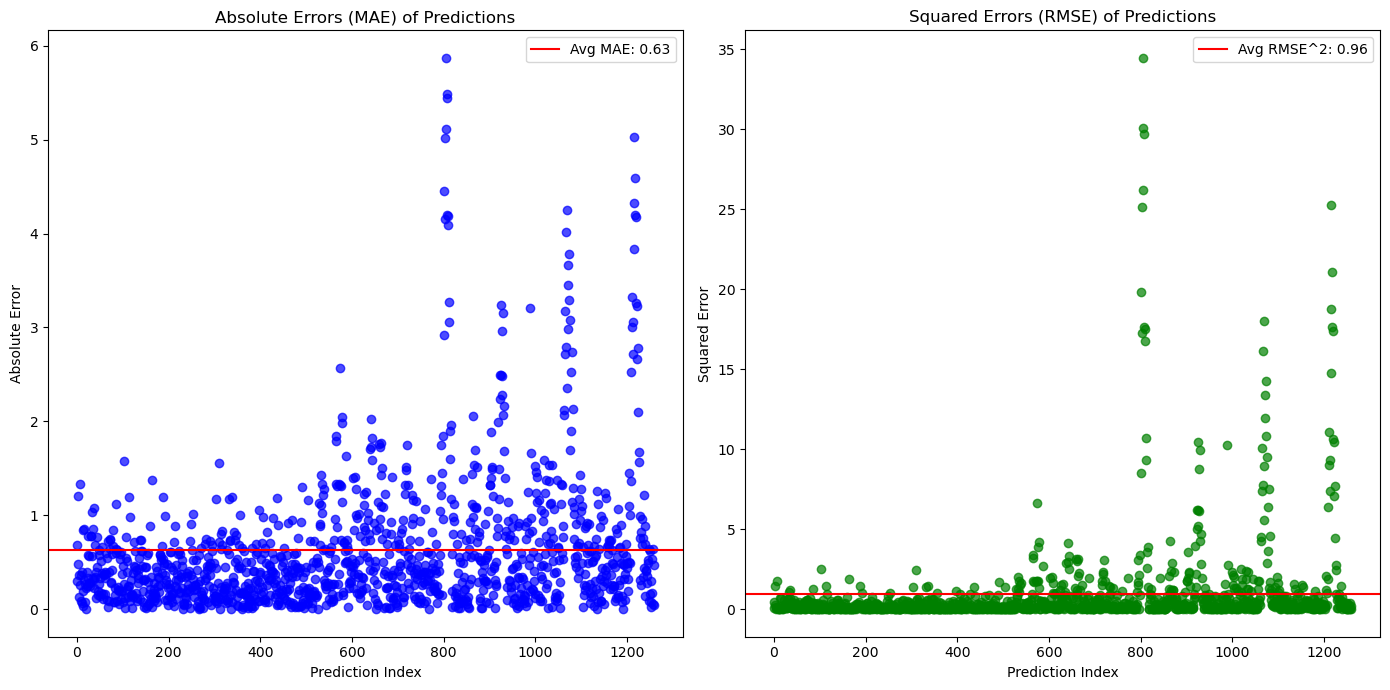

SVR-50 MAE: 0.6321, RMSE: 0.9821


In [5]:
# SVR Models
print("\nSVR Results:")
svr_5 = SVR(kernel='rbf', C=100, gamma=0.1)
mae_svr5, rmse_svr5 = train_evaluate(svr_5, X_train_5_scaled, X_test_5_scaled, y_train_5, y_test_5, 'SVR-5')
print(f"SVR-5 MAE: {mae_svr5:.4f}, RMSE: {rmse_svr5:.4f}\n")

svr_50 = SVR(kernel='rbf')
mae_svr50, rmse_svr50 = train_evaluate(svr_50, X_train_50_scaled, X_test_50_scaled, y_train_50, y_test_50, 'SVR-50')
print(f"SVR-50 MAE: {mae_svr50:.4f}, RMSE: {rmse_svr50:.4f}")

In [6]:
# LSTM Sequence Generation
def create_sequences(data, window_size, target_offset):
    X, y = [], []
    for i in range(len(data) - window_size - target_offset):
        X.append(data[['temperature']].values[i:i+window_size])
        y.append(data['temperature'].values[i+window_size+target_offset])
    return np.array(X), np.array(y)

window_size = 5
X_lstm, y_lstm = create_sequences(df, window_size, target_steps)

# Split data
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Scale data
scaler = StandardScaler().fit(X_train_lstm.reshape(-1, 1))
X_train_lstm_scaled = scaler.transform(X_train_lstm.reshape(-1, 1)).reshape(X_train_lstm.shape)
X_test_lstm_scaled = scaler.transform(X_test_lstm.reshape(-1, 1)).reshape(X_test_lstm.shape)

print("LSTM input shape:", X_train_lstm_scaled.shape)

LSTM input shape: (5075, 5, 1)


Note: you may need to restart the kernel to use updated packages.
Epoch 1/100
127/127 [==============================] - 5s 14ms/step - loss: 949.7751 - val_loss: 461.5668
Epoch 2/100
127/127 [==============================] - 1s 7ms/step - loss: 410.4560 - val_loss: 237.3307
Epoch 3/100
127/127 [==============================] - 1s 7ms/step - loss: 223.8685 - val_loss: 115.5179
Epoch 4/100
127/127 [==============================] - 1s 7ms/step - loss: 120.6770 - val_loss: 53.1926
Epoch 5/100
127/127 [==============================] - 1s 7ms/step - loss: 66.2790 - val_loss: 24.9006
Epoch 6/100
127/127 [==============================] - 1s 7ms/step - loss: 40.6344 - val_loss: 14.8140
Epoch 7/100
127/127 [==============================] - 1s 7ms/step - loss: 29.1384 - val_loss: 12.4543
Epoch 8/100
127/127 [==============================] - 1s 7ms/step - loss: 25.9513 - val_loss: 12.7435
Epoch 9/100
127/127 [==============================] - 1s 7ms/step - loss: 24.1124 - val_loss: 13.3867

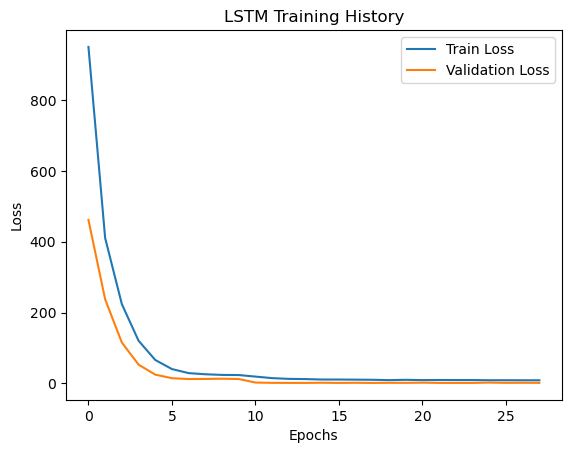

40/40 [==============================] - 1s 2ms/step


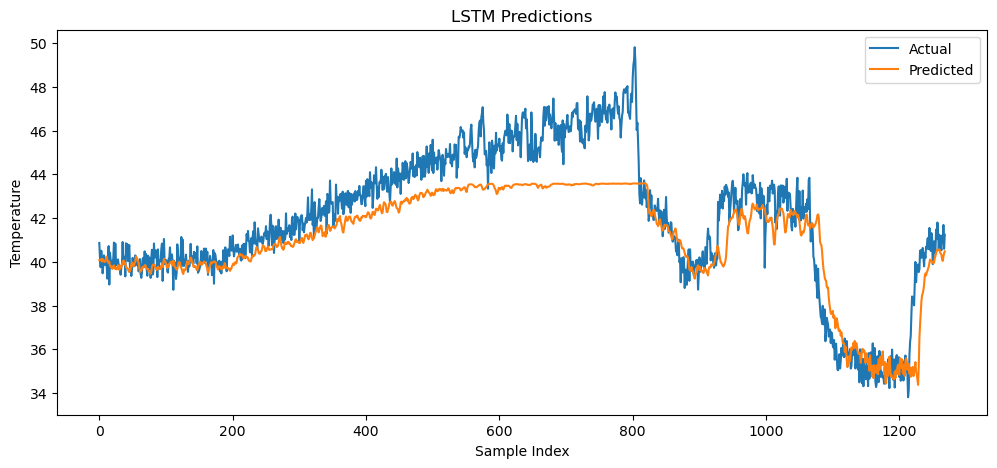

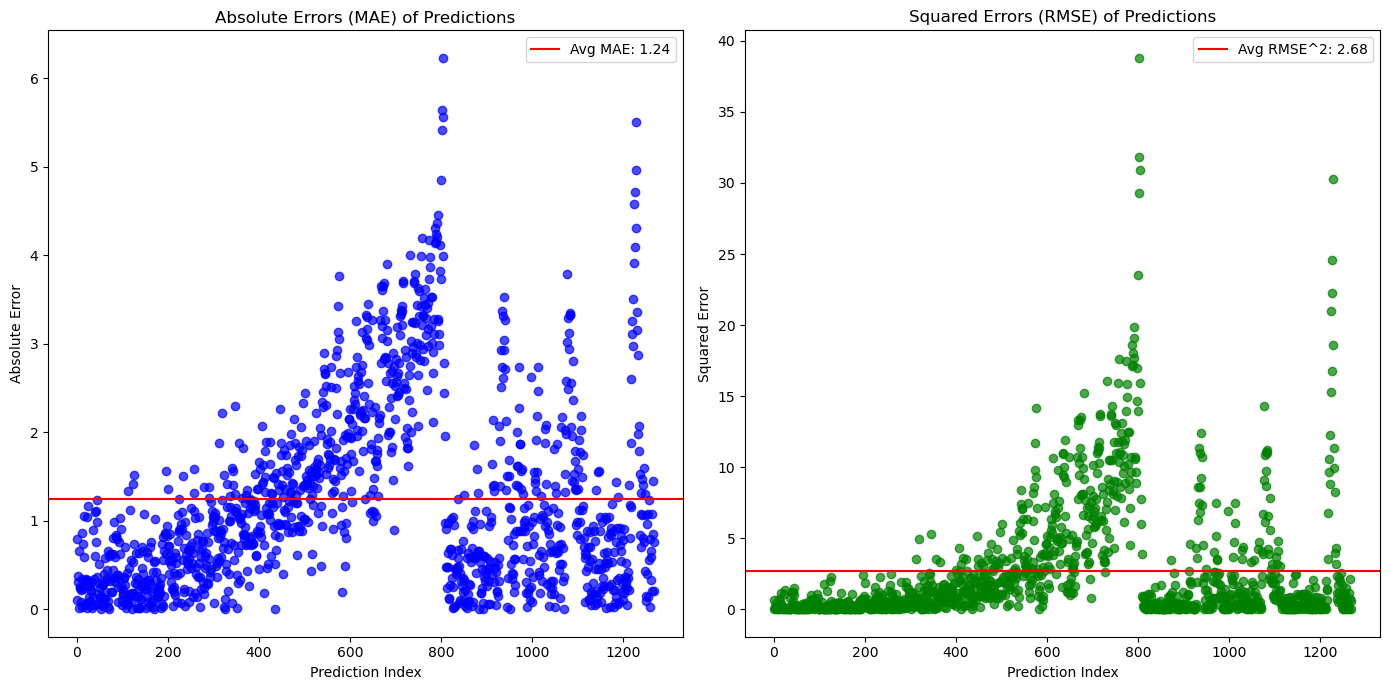

LSTM MAE: 1.2450, RMSE: 1.6375


In [8]:
%pip install tensorflow 
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Build an enhanced LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, 1)),  # Adjusted input shape
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Adjust learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train longer with early stopping
history = model.fit(
    X_train_lstm_scaled, y_train_lstm,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate
y_pred_lstm = model.predict(X_test_lstm_scaled).flatten()
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))

plt.figure(figsize=(12, 5))
plt.plot(y_test_lstm, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('LSTM Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Calculate individual absolute and squared errors
absolute_errors = np.abs(y_test_lstm - y_pred_lstm)
squared_errors = (y_test_lstm - y_pred_lstm) ** 2
# Create a scatter plot for MAE and RMSE across each prediction
plt.figure(figsize=(14, 7))

# Plotting absolute errors
plt.subplot(1, 2, 1)
plt.scatter(range(len(absolute_errors)), absolute_errors, color='blue', alpha=0.7)
plt.title('Absolute Errors (MAE) of Predictions')
plt.xlabel('Prediction Index')
plt.ylabel('Absolute Error')
plt.axhline(y=mae_lstm, color='r', linestyle='-', label=f'Avg MAE: {mae_lstm:.2f}')
plt.legend()



# Plotting squared errors
plt.subplot(1, 2, 2)
plt.scatter(range(len(squared_errors)), squared_errors, color='green', alpha=0.7)
plt.title('Squared Errors (RMSE) of Predictions')
plt.xlabel('Prediction Index')
plt.ylabel('Squared Error')
plt.axhline(y=rmse_lstm**2, color='r', linestyle='-', label=f'Avg RMSE^2: {rmse_lstm**2:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"LSTM MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")

In [9]:
# Final Comparison
results = pd.DataFrame({
    'Model': ['LR-5', 'LR-50', 'SVR-5', 'SVR-50', 'LSTM'],
    'MAE': [mae_lr5, mae_lr50, mae_svr5, mae_svr50, mae_lstm],
    'RMSE': [rmse_lr5, rmse_lr50, rmse_svr5, rmse_svr50, rmse_lstm]
})
print("Final Model Comparison:")
display(results)

Final Model Comparison:


,Model,MAE,RMSE
0,LR-5,0.709684,1.022474
1,LR-50,0.698423,1.007238
2,SVR-5,0.671935,0.992102
3,SVR-50,0.632111,0.982106
4,LSTM,1.244982,1.637495
